# Making masks for the ACC region and SIZ region
### writes out netcdf

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

In [2]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['diatC_zint','spC_zint','zooC_zint','SHF_QSW','SSH','IFRAC_JJAmean']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

diatC_zint
spC_zint
zooC_zint
SHF_QSW
SSH
IFRAC_JJAmean
CPU times: user 393 ms, sys: 28.3 ms, total: 422 ms
Wall time: 915 ms


In [3]:
ds['mesozooC'] = ds.zooC_zint * (ds.diatC_zint/(ds.diatC_zint + ds.spC_zint))
ds['diat_frac'] = ds.diatC_zint/(ds.diatC_zint + ds.spC_zint)

In [4]:
ds

<xarray.Dataset>
Dimensions:     (member_id: 34, nlat: 384, nlon: 320, time: 181, z_t: 60)
Coordinates:
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * member_id   (member_id) int64 1 2 9 10 11 12 13 ... 35 101 102 103 104 105
  * time        (time) int64 1920 1921 1922 1923 1924 ... 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    KMT         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz          (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    diatC_zint  (time, member_id, nlat, nlon) float64 dask.array<chunksize=(181, 34, 384, 320), meta=np.ndarray>
    spC_zint    (time, member_id, nlat, nlon) float64 dask.array<chunksize=(181, 34, 384, 320), meta=np.ndarray>
    zooC_zint   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(181, 34, 384, 320), meta=np.ndarray>
    SHF_QSW     (time, member_id, nlat, nlon) float64 dask.array<chunksize=(181, 34, 384, 320), meta=np.ndarray>
    SSH         (time, member_id, nlat, nlon) float64 dask.array<chunksize=(181, 34, 384, 320), meta=np.ndarray>
    IFRAC       (time, member_id, nlat, nlon) float64 dask.array<chunksize=(181, 34, 384, 320), meta=np.ndarray>
    mesozooC    (time, member_id, nlat, nlon) float64 dask.array<chunksize=(181, 34, 384, 320), meta=np.ndarray>
    diat_frac   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(181, 34, 384, 320), meta=np.ndarray>

### Necessary plotting function

In [5]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### get pop grid

In [6]:
grid = pop_tools.get_grid('POP_gx1v6')

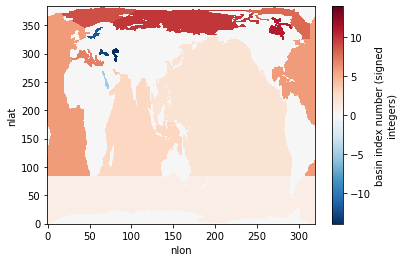

In [7]:
grid.REGION_MASK.plot()

In [8]:
lons = grid.TLONG
lats = grid.TLAT
years = ds.time.values
years

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

### mask out nans in ds

In [9]:
ds = ds.where(grid.REGION_MASK>0)

### extract 1920s

In [10]:
ds.time.isel(time=slice(0,10)).values

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929])

In [11]:
ds_1920s = ds.isel(time=slice(0,10)).mean(dim='time')

### extract 1990s

In [12]:
ds.time.isel(time=slice(70,80)).values

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999])

In [13]:
ds_1990s = ds.isel(time=slice(70,80)).mean(dim='time')

### Extract 2090s

In [14]:
ds.time.isel(time=slice(-11,-1)).values

array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [15]:
ds_2090s = ds.isel(time=slice(-11,-1)).mean(dim='time')

In [16]:
ensemble_mean_1920s = ds_1920s.mean(dim='member_id')
ensemble_mean_1990s = ds_1990s.mean(dim='member_id')
ensemble_mean_2090s = ds_2090s.mean(dim='member_id')

In [17]:
ensemble_mean_1990s.SSH

<xarray.DataArray 'SSH' (nlat: 384, nlon: 320)>
dask.array<mean_agg-aggregate, shape=(384, 320), dtype=float64, chunksize=(384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Sea Surface Height
    units:         centimeter
    grid_loc:      2110
    cell_methods:  time: mean

### SSH values at these points

In [18]:
################## define bounds
i_s_amer = 296
j_s_amer = 41

lat_s_amer = lats[j_s_amer,i_s_amer]
lon_s_amer = lons[j_s_amer,i_s_amer]

ssh_north = ensemble_mean_1920s.SSH[j_s_amer,i_s_amer]
#######################################

In [19]:
ssh_s_amer_1920s = ensemble_mean_1920s.SSH[j_s_amer,i_s_amer]
ssh_s_amer_1990s = ensemble_mean_1990s.SSH[j_s_amer,i_s_amer]
ssh_s_amer_2090s = ensemble_mean_2090s.SSH[j_s_amer,i_s_amer]

In [20]:
print('South America side SSH contour')
print(ssh_s_amer_1920s.values,ssh_s_amer_1990s.values,ssh_s_amer_2090s.values)

South America side SSH contour
-81.495038757939 -83.76555096603997 -102.77266623694506


### Use JJA IFRAC=0.85 for the SIZ mask and just upper SSH bound

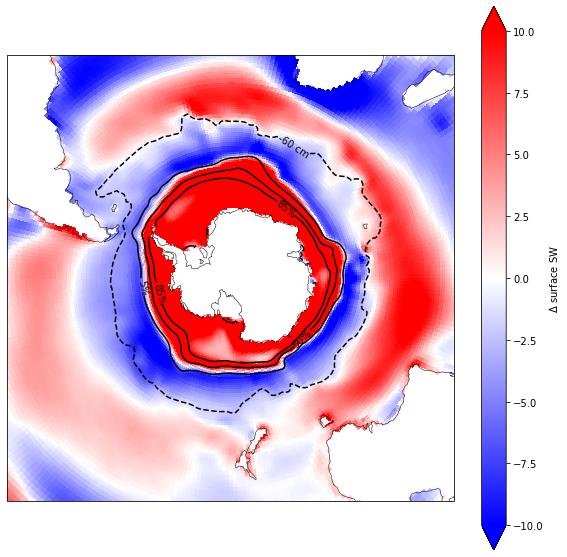

In [21]:
fig = plt.figure(figsize=(10,10))

lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_2090s.SHF_QSW- ensemble_mean_1920s.SHF_QSW)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

pc=ax.pcolormesh(lon, lat, 
                 field, #vmin=ssh_south, vmax=ssh_north, 
                 cmap='bwr',
                 vmin=-10,vmax=10,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_1990s.SSH)
pci=ax.contour(lon, lat, field,levels=[-60],colors='black',transform=ccrs.PlateCarree())
fmt = {}
strs = ['-60 cm']
for l, s in zip(pci.levels, strs):
    fmt[l] = s
ax.clabel(pci, pci.levels, inline=True, fmt=fmt, fontsize=10)

lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_1990s.IFRAC)
pci=ax.contour(lon, lat, field,levels=[0.05,0.5,0.85],colors='black',transform=ccrs.PlateCarree())
strs = ['5%','50%','85%']
for l, s in zip(pci.levels, strs):
    fmt[l] = s
ax.clabel(pci, pci.levels, inline=True, fmt=fmt, fontsize=10)

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ surface SW')


## 1990s

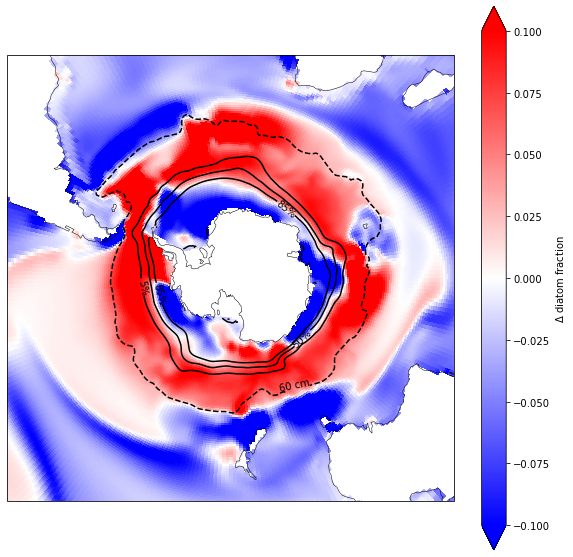

In [22]:
fig = plt.figure(figsize=(10,10))

lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_2090s.diat_frac- ensemble_mean_1920s.diat_frac)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

pc=ax.pcolormesh(lon, lat, 
                 field, #vmin=ssh_south, vmax=ssh_north, 
                 cmap='bwr',
                 vmin=-0.1,vmax=0.1,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_1990s.SSH)
pci=ax.contour(lon, lat, field,levels=[-60],colors='black',transform=ccrs.PlateCarree())
fmt = {}
strs = ['60 cm']
for l, s in zip(pci.levels, strs):
    fmt[l] = s
ax.clabel(pci, pci.levels, inline=True, fmt=fmt, fontsize=10)

lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_1990s.IFRAC)
pci=ax.contour(lon, lat, field,levels=[0.05,0.5,0.85],colors='black',transform=ccrs.PlateCarree())
strs = ['5%','50%','85%']
for l, s in zip(pci.levels, strs):
    fmt[l] = s
ax.clabel(pci, pci.levels, inline=True, fmt=fmt, fontsize=10)

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ diatom fraction')


### make masking files

In [23]:
ones = np.full((384,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))

#### ACC mask is defined as between surface sigma 26.4 & 26.9 in the Southern Ocean outside of the sea ice zone

In [24]:
ACC_mask = ones.where(lats<0.).where(ensemble_mean_1990s.SSH<-60).where(ensemble_mean_1990s.IFRAC<0.05) #.where(ensemble_mean_1990s.SSH>-180.)

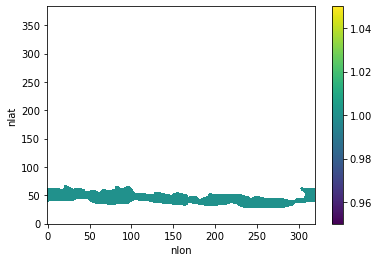

In [25]:
ACC_mask.plot()

In [26]:
SIZ_mask = ones.where(lats<0.).where(ensemble_mean_1990s.IFRAC>=0.85) #ACC_mask!= 1).where(ensemble_mean_1990s.SSH<-60) #

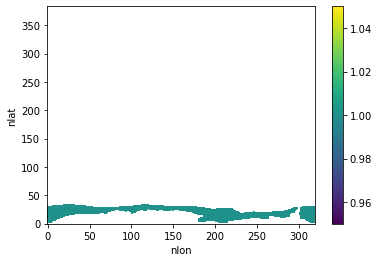

In [27]:
SIZ_mask.plot()

### find min, max, mean latitude of each region

In [30]:
masked = ds['TLAT'].where(ACC_mask==1.)
lat_ACC = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()
lat_ACC.values

array(-54.7822978)

In [38]:
np.nanmin(masked.values)

-64.26237479780082

In [39]:
np.nanmax(masked.values)

-43.42731262373764

In [40]:
masked = ds['TLAT'].where(SIZ_mask==1.)
lat_SIZ = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()
lat_SIZ.values

array(-67.99550759)

In [41]:
np.nanmin(masked.values)

-78.15208991787753

In [42]:
np.nanmax(masked.values)

-61.5912500929445

### Define marginal sea ice zone (not including in analysis)

In [36]:
margSIZ_mask = ensemble_mean_1990s.IFRAC.where(lats<0.).where(ensemble_mean_1990s.IFRAC>0.05).where(ensemble_mean_1990s.IFRAC<0.85)

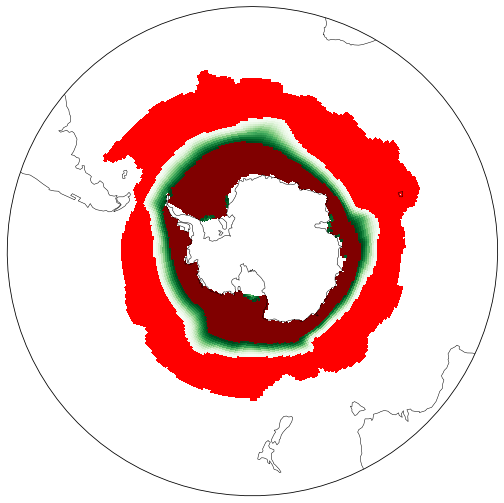

In [38]:
fig = plt.figure(figsize=(10,9))

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle


lon, lat, field = adjust_pop_grid(lons, lats, ACC_mask)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.1, vmax=0.1, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)


lon, lat, field = adjust_pop_grid(lons, lats, SIZ_mask)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.1, vmax=0.1, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

lon, lat, field = adjust_pop_grid(lons, lats, margSIZ_mask)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=0.05, vmax=0.85, 
                 cmap='Greens',
                 transform=ccrs.PlateCarree())


# lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_1990s.SSH)
# #pci=ax.contour(lon, lat, field,levels=[-60],colors='black',transform=ccrs.PlateCarree())

# lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_1990s.IFRAC)
# #pci=ax.contour(lon, lat, field,levels=[0.85],colors='black',transform=ccrs.PlateCarree())

### write out data

In [39]:
ds_masks = xr.Dataset()
ds_masks['ACC_mask'] = ACC_mask
ds_masks['SIZ_mask'] = SIZ_mask
ds_masks['marginal_SIZ_mask'] = margSIZ_mask

In [41]:
outfile='/glade/work/kristenk/TTE_CESM-LE/masks_1990s_v3.nc'
ds_masks.to_netcdf(outfile)